# Introduction

### In this notebook we shall try to predict with xgboost the purchase value as well as the purchase count of a product, given it's intrinsic attributes. 

### In Section 1) we perform the preprocessing of the data

### in Section 2) we try to predict purchase value from a set of categorical and numerical attributes 

### in section 3) we do the same as section in 2) but only with categorical attributes

### in section 4) we try to predict purchase count from categorical and numerical attributes

In [1]:
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import numpy as np
import seaborn as sns 
import copy
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import xgboost as xgb

In [2]:
%config Completer.use_jedi = False

In [3]:
sales_df = pd.read_csv("sales_table.csv", delimiter=';')
sales_df = sales_df.drop(0)
sales_df = sales_df.reset_index(drop=True)
sales_df

,purchase_id,product_id,affiliate_id,producer_id,buyer_id,purchase_date,product_creation_date,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network
0,1663958,6640,209372,116238,1200397,2016-06-26 12:00:00,2011-03-19 15:47:36,Video,Presentation skills,-0.265302,50.0,Smart TV,Origin ef2b,"0,0"
1,1677087,2350,141418,2821,1083764,2016-06-26 12:00:00,2010-07-05 01:50:15,Podcast,Child psychology,-0.177077,60.0,Smart TV,Origin ef2b,"0,0"
2,2017360,35669,618642,618642,1436106,2016-06-26 12:00:00,2012-06-13 02:59:37,Podcast,Presentation skills,-0.468989,0.0,Smart TV,Origin ef2b,"0,0"
3,2017379,57998,1164511,70388,1436118,2016-06-26 12:00:00,2013-05-07 08:51:31,Podcast,Anxiety management,-0.401168,50.0,Smart TV,Origin ef2b,"0,0"
4,2017382,58329,1261488,221253,1386357,2016-06-26 12:00:00,2013-05-12 08:12:06,Podcast,Teaching English,-0.452489,50.0,Smart TV,Origin ef2b,"0,0"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599823,14011995,238362,7586641,7586641,5736172,2016-06-30 23:59:57,2016-06-16 12:10:46,Phisical book,Personal finance,-0.345361,0.0,eReaders,Origin 3022,"0,0"
1599824,14012431,61279,589022,589022,946067,2016-06-30 21:40:11,2013-06-15 16:41:06,Phisical book,Personal finance,-0.471786,0.0,Smart TV,Origin ef2b,"0,0"
1599825,14343996,215242,1186145,1186145,6473172,2016-05-13 16:45:42,2016-03-26 17:59:47,Phisical book,Negotiation,-0.359158,0.0,Smart TV,Origin ef2b,"0,0"
1599826,14344113,215242,1186145,1186145,6473172,2016-06-22 14:39:05,2016-03-26 17:59:47,Phisical book,Negotiation,-0.359158,0.0,Smart TV,Origin ef2b,"0,0"



### Here we define some functions that will be used through this notebook

In [4]:

#reindexes the dataframe to make it centered around a given column
def get_reindexed_df(df, new_index_column, columns_list):
    
    df = sales_df.reindex(columns=new_index_column + columns_list)
    df = df.sort_values(by=new_index_column).reset_index(drop=True)
    
    return df

#gets a categorical column and converts each of its category types to one-hot representation
def category_to_one_hot(df, column):
    
    category_list = df[column].unique()
    one_hot_df = pd.get_dummies(category_list, prefix='%s_' % column)
    one_hot_df[column] = category_list
    pre_len = len(df)
    df = df.merge(one_hot_df, on=[column], how="left")
    assert len(df) == pre_len
    
    return df, one_hot_df

#converts a list of categorical feature columns in a df to one-hot representation
def get_one_hot_user_cat_columns(user_df, columns_list):
    
    for col in columns_list:
        user_df, one_hot_df = category_to_one_hot(df = user_df, column = col )    
        
    return user_df

# 1) Proprocessing
### XGBoost uses a boosting approach with tree algorithms, which can only be trained with numerical features-attributes. Since many categorical columns in our dataset are conceptually likely to be good predictors of price and purchase count, we need to turn them into a numerical representation. We choose one-hot, since with this representation we can prevent XGBoost from learning distance metrics between different categories, which wouldn't mean anything. 

### Some columns do not refer to characteristics that are intrinsic to each product, users ids, so we eliminate these. We will also drop purchase date and creation date, however we would like to have realized an extra experiment considering the time interval between purchase and creation, which might correlate with purchase counts, but unfortunately the deadline was reached before we could do that. 

### The first step is to turn the dataframe product-centered and drop columns that won't be used:

In [5]:
#reindexing the dataframe to turn it into product-centered with "producer_niche" features
product_df = get_reindexed_df(sales_df, new_index_column = ['product_id'], columns_list=sales_df.columns.tolist()[2:])
product_df = product_df.drop(['product_creation_date', 'purchase_date', 'buyer_id', 'producer_id', 'affiliate_id'], axis=1)
product_df

,product_id,product_category,product_niche,purchase_value,affiliate_commission_percentual,purchase_device,purchase_origin,is_origin_page_social_network
0,4,Podcast,Disease,-0.535608,0.0,Desktop,Origin 5187,"0,0"
1,4,Podcast,Disease,-0.535608,0.0,Desktop,Origin 5187,"0,0"
2,17,Podcast,Personal finance,-0.467093,47.0,eReaders,Origin adf0,"0,0"
3,27,Podcast,Presentation skills,-0.522656,0.0,Desktop,Origin adf0,"0,0"
4,27,Podcast,Presentation skills,-0.522656,50.0,Desktop,Origin adf0,"0,0"
...,...,...,...,...,...,...,...,...
1599823,241896,Phisical book,Presentation skills,-0.357281,0.0,eReaders,Origin 221a,"0,0"
1599824,241903,Phisical book,Negotiation,-0.539363,0.0,Desktop,Origin eb16,"0,0"
1599825,241977,Phisical book,Presentation skills,0.209612,0.0,Desktop,Origin 5187,"0,0"
1599826,319129,Phisical book,Negotiation,3.496920,30.0,Desktop,Origin 6c05,"0,0"



### Before we convert each categorical attribute to one-hot, we need to reduce the number of categories for the 'purchase_origin' attribute, since there are too many, and it would be unfeasable to represent it with one-hot. We select the top 4 most occuring categories for 'purchase_origin' and create a 5th category called 'Origin other' to represent all the other categories that aren't the top 4 most present.

In [6]:
top4 = product_df['purchase_origin'].value_counts()[0:4].index.tolist() 
product_df['purchase_origin'] = product_df['purchase_origin'].apply(lambda origin: origin if origin in top4 else 'Origin other')
product_df['purchase_origin'].value_counts()

Origin other    996173
Origin ef2b     330077
Origin 5187     167028
Origin adf0      77857
Origin 18eb      28693
Name: purchase_origin, dtype: int64


### Now we convert all categorical columns to one-hot

In [7]:
columns_to_one_hot = ['product_niche', 'product_category', 'purchase_device', 'purchase_origin', 'purchase_device','is_origin_page_social_network']
product_df= get_one_hot_user_cat_columns(product_df, columns_list = columns_to_one_hot)
product_df = product_df.select_dtypes(exclude=['object'])

In [8]:
product_df

,product_id,purchase_value,affiliate_commission_percentual,product_niche__Accounting,product_niche__Anxiety management,product_niche__Biology,product_niche__Careers,product_niche__Child psychology,product_niche__Disease,product_niche__Economics,...,purchase_origin__Origin adf0,purchase_origin__Origin ef2b,purchase_origin__Origin other,purchase_device__Cellphone_y,purchase_device__Desktop_y,purchase_device__Smart TV_y,purchase_device__Tablet_y,purchase_device__eReaders_y,"is_origin_page_social_network__0,0","is_origin_page_social_network__1,0"
0,4,-0.535608,0.0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
1,4,-0.535608,0.0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
2,17,-0.467093,47.0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
3,27,-0.522656,0.0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
4,27,-0.522656,50.0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599823,241896,-0.357281,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
1599824,241903,-0.539363,0.0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
1599825,241977,0.209612,0.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1599826,319129,3.496920,30.0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0


In [9]:
product_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1599828 entries, 0 to 1599827
Data columns (total 55 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   product_id                             1599828 non-null  int64  
 1   purchase_value                         1599828 non-null  float64
 2   affiliate_commission_percentual        1599828 non-null  float64
 3   product_niche__Accounting              1599828 non-null  uint8  
 4   product_niche__Anxiety management      1599828 non-null  uint8  
 5   product_niche__Biology                 1599828 non-null  uint8  
 6   product_niche__Careers                 1599828 non-null  uint8  
 7   product_niche__Child psychology        1599828 non-null  uint8  
 8   product_niche__Disease                 1599828 non-null  uint8  
 9   product_niche__Economics               1599828 non-null  uint8  
 10  product_niche__Filmmaking              159


### Now we concatenate duplicate rows, i.e., rows relative to the same product id, which are present due to the different purchases from the same product. Additionally, an extra column called 'purchase_counts' at the end of the dataframe is created to store the duplicate counts of each product, which is the same as their purchase count

In [10]:
product_df = product_df.groupby(product_df.columns.tolist(),as_index=False).size()
product_df.columns = product_df.columns[:-1].tolist() + ['purchase_counts']

In [11]:
product_df

,product_id,purchase_value,affiliate_commission_percentual,product_niche__Accounting,product_niche__Anxiety management,product_niche__Biology,product_niche__Careers,product_niche__Child psychology,product_niche__Disease,product_niche__Economics,...,purchase_origin__Origin ef2b,purchase_origin__Origin other,purchase_device__Cellphone_y,purchase_device__Desktop_y,purchase_device__Smart TV_y,purchase_device__Tablet_y,purchase_device__eReaders_y,"is_origin_page_social_network__0,0","is_origin_page_social_network__1,0",purchase_counts
0,4,-0.535608,0.0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,2
1,17,-0.467093,47.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1
2,27,-0.522656,0.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
3,27,-0.522656,50.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
4,35,-0.504260,60.0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231823,241896,-0.331189,0.0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,1
231824,241903,-0.539363,0.0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,1,0,1
231825,241977,0.209612,0.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1
231826,319129,3.423260,20.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,1


# 2) Purchase value prediction w/ categorical attributes + affiliate commission 
### In this section we perform the first prediction of purchase value of each product given it's categorical and numerical attributes

### firstly we select y, the target that is represented by the 'purchase_value' column

In [12]:
y = product_df[['purchase_value']]

In [13]:
y

,purchase_value
0,-0.535608
1,-0.467093
2,-0.522656
3,-0.522656
4,-0.504260
...,...
231823,-0.331189
231824,-0.539363
231825,0.209612
231826,3.423260


### Then we select X, our attributes, which we do by simply dropping 'purchase_counts' and 'purchase_value', which are meant to be predicted, and 'product_id', which is not meaningful for the prediction. 

### Note that the only numerical attribute, i.e. not represented in one-hot, is 'affiliate_commission_percentual'. XGBoost isn't sensetive to attribute scaling, so there's no need for normalization/standardization preprocessing for this attribute.

In [14]:
X = product_df.drop(['purchase_value', 'purchase_counts', 'product_id'], axis=1)

In [15]:
X

,affiliate_commission_percentual,product_niche__Accounting,product_niche__Anxiety management,product_niche__Biology,product_niche__Careers,product_niche__Child psychology,product_niche__Disease,product_niche__Economics,product_niche__Filmmaking,product_niche__Genetics,...,purchase_origin__Origin adf0,purchase_origin__Origin ef2b,purchase_origin__Origin other,purchase_device__Cellphone_y,purchase_device__Desktop_y,purchase_device__Smart TV_y,purchase_device__Tablet_y,purchase_device__eReaders_y,"is_origin_page_social_network__0,0","is_origin_page_social_network__1,0"
0,0.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,47.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
2,0.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
3,50.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
4,60.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231823,0.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
231824,0.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
231825,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
231826,20.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


### And then we split our data in 80% train, 10% validation, and 10% test

In [16]:
X_train, X_non_train, y_train, y_non_train= train_test_split(X, y, random_state=1, test_size=0.2)

In [17]:
X_val, X_test, y_val, y_test = train_test_split(X_non_train, y_non_train, random_state=1, test_size=0.5)

In [18]:
print(X_train.shape, X_val.shape, X_test.shape)

(185462, 53) (23183, 53) (23183, 53)


In [19]:
print(y_train.shape, y_val.shape, y_test.shape)

(185462, 1) (23183, 1) (23183, 1)


### Now we begin the training. We've performed some basic fine tunning of the model with the train and validation sets, and arrived at this hyperparameter choice. max_depth is one of the most critical attributes, controlling the max deapth of each tree during the boosting, which directly affects the capacity of the model. 

[0]	validation_0-rmse:1.46123	validation_1-rmse:1.28657
[1]	validation_0-rmse:1.45435	validation_1-rmse:1.27907
[2]	validation_0-rmse:1.44811	validation_1-rmse:1.27220
[3]	validation_0-rmse:1.44222	validation_1-rmse:1.26581
[4]	validation_0-rmse:1.43693	validation_1-rmse:1.26009
[5]	validation_0-rmse:1.43174	validation_1-rmse:1.25438
[6]	validation_0-rmse:1.42698	validation_1-rmse:1.24919
[7]	validation_0-rmse:1.42267	validation_1-rmse:1.24448
[8]	validation_0-rmse:1.41900	validation_1-rmse:1.24047
[9]	validation_0-rmse:1.41542	validation_1-rmse:1.23655
[10]	validation_0-rmse:1.41232	validation_1-rmse:1.23317
[11]	validation_0-rmse:1.40922	validation_1-rmse:1.22955
[12]	validation_0-rmse:1.40627	validation_1-rmse:1.22629
[13]	validation_0-rmse:1.40388	validation_1-rmse:1.22365
[14]	validation_0-rmse:1.40151	validation_1-rmse:1.22086
[15]	validation_0-rmse:1.39937	validation_1-rmse:1.21851
[16]	validation_0-rmse:1.39729	validation_1-rmse:1.21627
[17]	validation_0-rmse:1.39560	validation

<AxesSubplot:>

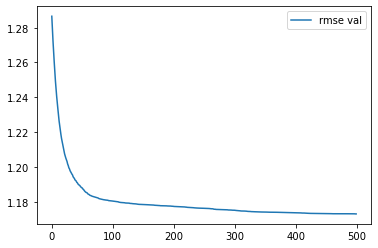

In [20]:

xg_model = XGBRegressor(verbosity=1, n_estimators=500, learning_rate=0.05, max_depth=8)
xg_model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)
max_estimators = len(xg_model.evals_result()['validation_1']['rmse'])
print(max_estimators)
pd.DataFrame(xg_model.evals_result()['validation_1']['rmse'], columns=['rmse val']).plot()


### Here is the plot with the rmse metric evolution for the train and test sets. It's clearly underfitting, which most likely means that data we selected for our attributes doesn't offer a lot of information for predicting the targets we are trying to predict. However, some small portion of the loss was still minimized. 

<AxesSubplot:>

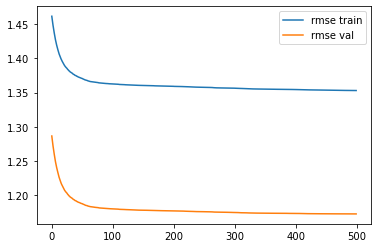

In [21]:
pd.DataFrame(np.transpose([xg_model.evals_result()['validation_0']['rmse'], xg_model.evals_result()['validation_1']['rmse']]), columns=['rmse train', 'rmse val']).plot()


### Here we plot the mean absolute error for the train, val and test sets. We can see that they do not greatly differ. However they are inside the interval defined by the std of each target, which means that our model was able to learn something slightly helpfull in reducing uncertainty. 

In [22]:
predictions = xg_model.predict(X_train)
print("Train Mean Absolute Error : {}".format(mean_absolute_error(predictions, y_train)))
print("Train Targets std: {}".format(np.sqrt(y_train.var().item())))

Train Mean Absolute Error : 0.6293149003785544
Train Targets std: 1.4560188058428587


In [23]:
predictions = xg_model.predict(X_val)
print("Validation Mean Absolute Error : {}".format(mean_absolute_error(predictions, y_val)))
print("Validation Targets std: {}".format(np.sqrt(y_val.var().item())))

Validation Mean Absolute Error : 0.622385914178335
Validation Targets std: 1.2783219771870755


In [24]:
predictions = xg_model.predict(X_test)
print("Test Mean Absolute Error : {}".format(mean_absolute_error(predictions, y_test)))
print("Test Targets std: {}".format(np.sqrt(y_test.var().item())))

Test Mean Absolute Error : 0.6326355163748567
Test Targets std: 1.5841430514218873


### Here we plot 3 graps for the feature importance for 3 different criterea considered in XGBoost: "weight", "cover" and "gain". 

### - "Weight" measures the number of the number of times a feature is used to split the data across all trees
### - "Cover" is similar to "weight", but additionally it weights the count by the number of data points that go through each split
### - "Gain" measures how much loss the model was able to reducem on average when using a certain feature for splitting

### By the "Gain" graph, we can clearly see that affiliate_commission_percentual dominates, which might be due to the fact that it is the only numerical feature, and each tree can use multiple intervals of this attribute for performing each split. For the "cover" graph, the attributes are more equally important, with some dominance of "product_niche_Travel_hacking". For the "gain" graph, which we believe is more meaningful, product_category_Podcast and product_niche_Acounting were the two most important.

<AxesSubplot:title={'center':'Feature importance: gain'}, xlabel='F score', ylabel='Features'>

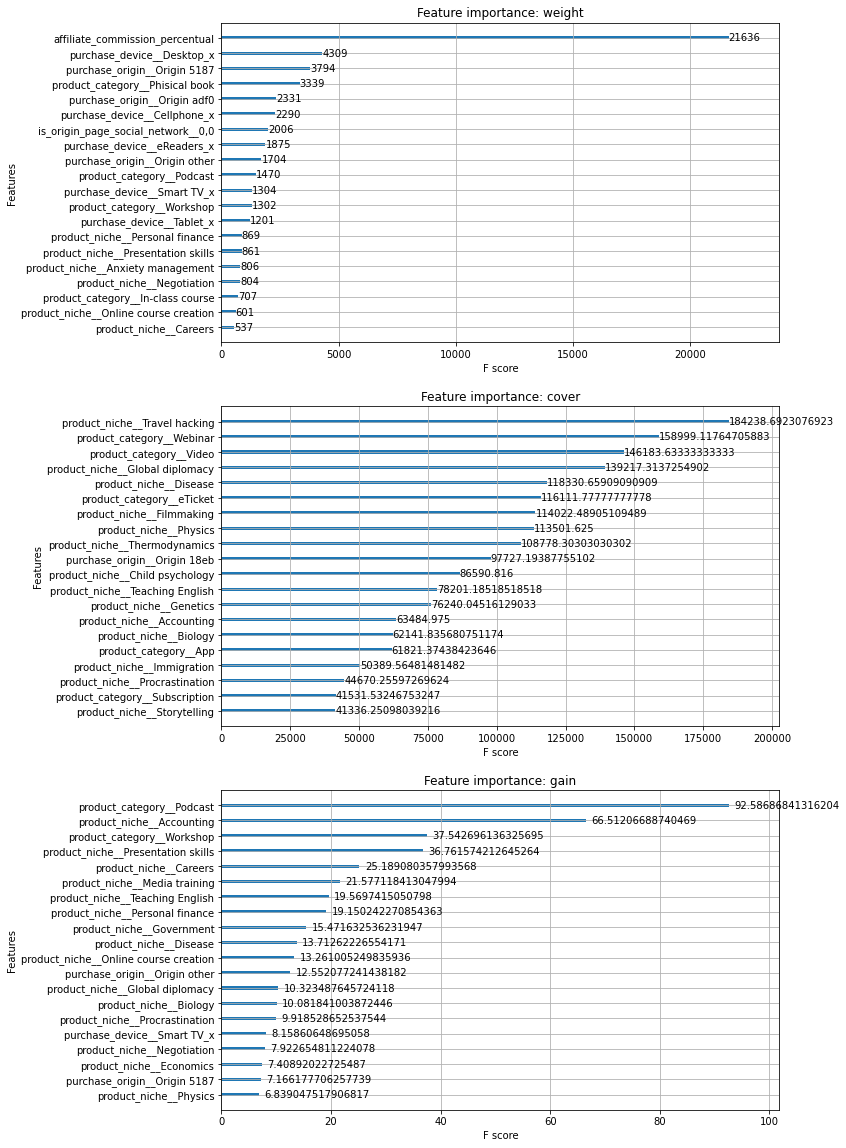

In [25]:

fig, ax = plt.subplots(figsize=(10,20), nrows=3)
xgb.plot_importance(xg_model, max_num_features=20,importance_type='weight', ax=ax[0], title='Feature importance: weight')
xgb.plot_importance(xg_model, max_num_features=20,importance_type='cover', ax=ax[1], title='Feature importance: cover')
xgb.plot_importance(xg_model, max_num_features=20,importance_type='gain', ax=ax[2], title='Feature importance: gain')

# 3) Purchase value prediction w/ ONLY categorical attributes 
### In this section we perform the second prediction of purchase value of each product given ONLY it's categorical attributes

### we do this to verify if XGBoost is dealing well with both categorical and numerical attributes, and also to try to determine if the numerical attribute given by affiliate_commission_percentual variable is in fact being meaningful for the prediction, as was indicated by the feature importance graph with the "weight" criterium. 

In [26]:
y = product_df[['purchase_value']]

In [27]:
y

,purchase_value
0,-0.535608
1,-0.467093
2,-0.522656
3,-0.522656
4,-0.504260
...,...
231823,-0.331189
231824,-0.539363
231825,0.209612
231826,3.423260


### now we also drop affiliate_commission_percentual

In [28]:
X = product_df.drop(['purchase_value', 'purchase_counts', 'product_id', 'affiliate_commission_percentual'], axis=1)

In [29]:
X

,product_niche__Accounting,product_niche__Anxiety management,product_niche__Biology,product_niche__Careers,product_niche__Child psychology,product_niche__Disease,product_niche__Economics,product_niche__Filmmaking,product_niche__Genetics,product_niche__Global diplomacy,...,purchase_origin__Origin adf0,purchase_origin__Origin ef2b,purchase_origin__Origin other,purchase_device__Cellphone_y,purchase_device__Desktop_y,purchase_device__Smart TV_y,purchase_device__Tablet_y,purchase_device__eReaders_y,"is_origin_page_social_network__0,0","is_origin_page_social_network__1,0"
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231823,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
231824,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
231825,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
231826,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


### Same train, val, test split as used in section 2), with the same random state

In [30]:
X_train, X_non_train, y_train, y_non_train= train_test_split(X, y, random_state=1, test_size=0.2)

In [31]:
X_val, X_test, y_val, y_test = train_test_split(X_non_train, y_non_train, random_state=1, test_size=0.5)

In [32]:
print(X_train.shape, X_val.shape, X_test.shape)

(185462, 52) (23183, 52) (23183, 52)


In [33]:
print(y_train.shape, y_val.shape, y_test.shape)

(185462, 1) (23183, 1) (23183, 1)


### Same hyperparameters used in section 2)

[0]	validation_0-rmse:1.46184	validation_1-rmse:1.28714
[1]	validation_0-rmse:1.45553	validation_1-rmse:1.28015
[2]	validation_0-rmse:1.44983	validation_1-rmse:1.27387
[3]	validation_0-rmse:1.44442	validation_1-rmse:1.26786
[4]	validation_0-rmse:1.43955	validation_1-rmse:1.26246
[5]	validation_0-rmse:1.43514	validation_1-rmse:1.25755
[6]	validation_0-rmse:1.43113	validation_1-rmse:1.25311
[7]	validation_0-rmse:1.42750	validation_1-rmse:1.24910
[8]	validation_0-rmse:1.42421	validation_1-rmse:1.24544
[9]	validation_0-rmse:1.42123	validation_1-rmse:1.24217
[10]	validation_0-rmse:1.41850	validation_1-rmse:1.23921
[11]	validation_0-rmse:1.41606	validation_1-rmse:1.23649
[12]	validation_0-rmse:1.41383	validation_1-rmse:1.23407
[13]	validation_0-rmse:1.41175	validation_1-rmse:1.23182
[14]	validation_0-rmse:1.40991	validation_1-rmse:1.22979
[15]	validation_0-rmse:1.40820	validation_1-rmse:1.22789
[16]	validation_0-rmse:1.40664	validation_1-rmse:1.22620
[17]	validation_0-rmse:1.40522	validation

<AxesSubplot:>

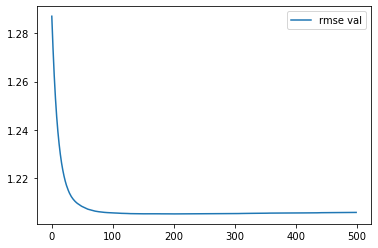

In [34]:

xg_model = XGBRegressor(verbosity=1, n_estimators=500, learning_rate=0.05, max_depth=8)
xg_model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)
max_estimators = len(xg_model.evals_result()['validation_1']['rmse'])
print(max_estimators)
pd.DataFrame(xg_model.evals_result()['validation_1']['rmse'], columns=['rmse val']).plot()


### Again, we notice a underfitting due to the train loss being a lot greater than the validation loss

<AxesSubplot:>

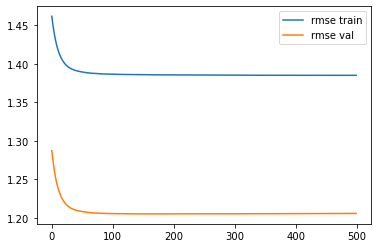

In [35]:
pd.DataFrame(np.transpose([xg_model.evals_result()['validation_0']['rmse'], xg_model.evals_result()['validation_1']['rmse']]), columns=['rmse train', 'rmse val']).plot()


### We can notice a slightly increase in the mean absolute error loss, which was approx 0.62 in 2) and now is approx 0.66. This indicates that the attribute affiliate_commission_percentual, which was removed, had some slight predictive importance for the product purchase value. 

In [36]:
predictions = xg_model.predict(X_train)
print("Train Mean Absolute Error : {}".format(mean_absolute_error(predictions, y_train)))
print("Train Targets std: {}".format(np.sqrt(y_train.var().item())))

Train Mean Absolute Error : 0.6629811975117226
Train Targets std: 1.4560188058428587


In [37]:
predictions = xg_model.predict(X_val)
print("Validation Mean Absolute Error : {}".format(mean_absolute_error(predictions, y_val)))
print("Validation Targets std: {}".format(np.sqrt(y_val.var().item())))

Validation Mean Absolute Error : 0.6520699590449875
Validation Targets std: 1.2783219771870755


In [38]:
predictions = xg_model.predict(X_test)
print("Test Mean Absolute Error : {}".format(mean_absolute_error(predictions, y_test)))
print("Test Targets std: {}".format(np.sqrt(y_test.var().item())))

Test Mean Absolute Error : 0.6636464871062786
Test Targets std: 1.5841430514218873


### By creating new feature importance plots for this training, we can observe that tthe graphs are all very similar to the experiment conducted in 2), except for the lack of the removed attribute.

<AxesSubplot:title={'center':'Feature importance: gain'}, xlabel='F score', ylabel='Features'>

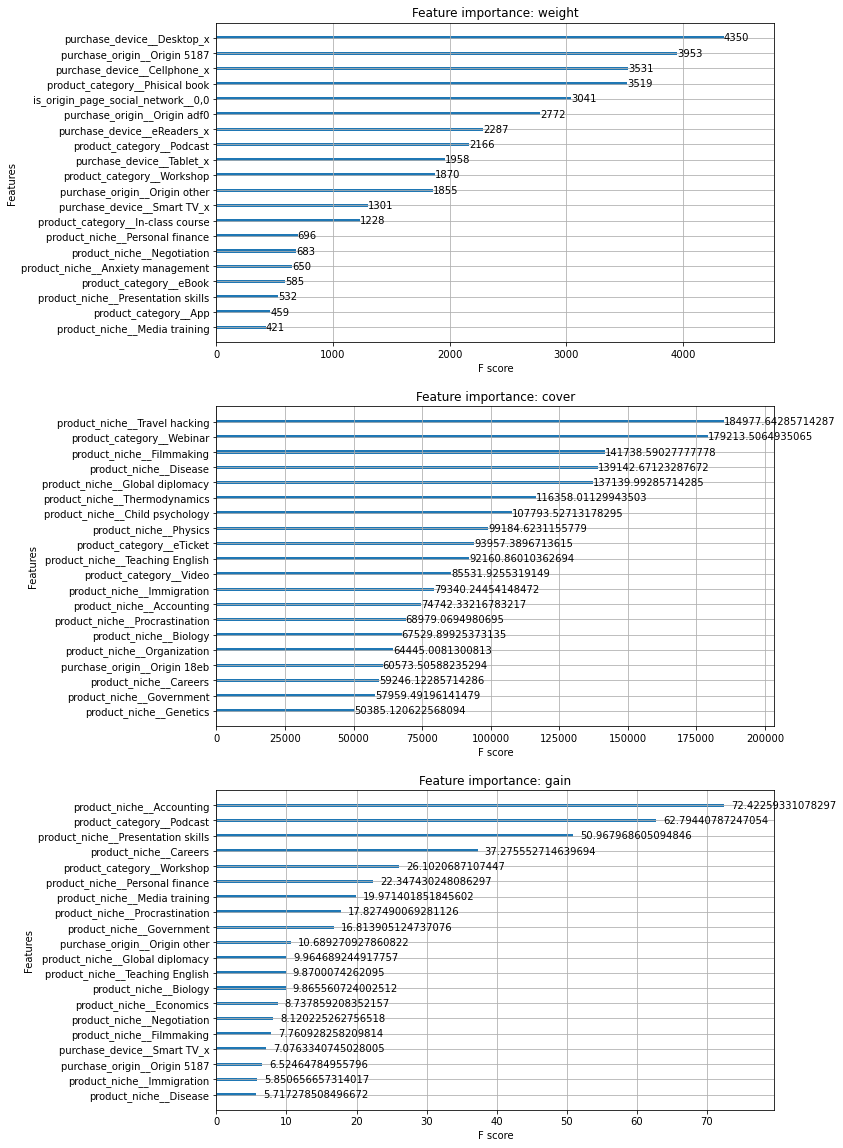

In [39]:

fig, ax = plt.subplots(figsize=(10,20), nrows=3)
xgb.plot_importance(xg_model, max_num_features=20,importance_type='weight', ax=ax[0], title='Feature importance: weight')
xgb.plot_importance(xg_model, max_num_features=20,importance_type='cover', ax=ax[1], title='Feature importance: cover')
xgb.plot_importance(xg_model, max_num_features=20,importance_type='gain', ax=ax[2], title='Feature importance: gain')

# 4) Purchase count prediction w/ categorical attributes + affiliate commission 
### In this section we perform a product count prediction, differently from the experiments in section 2) and 3) which predicted product value.

### firstly we select y, the target that is represented by the 'purchase_counts' column

In [40]:
y = product_df[['purchase_counts']]

In [41]:
y

,purchase_counts
0,2
1,1
2,1
3,1
4,3
...,...
231823,1
231824,1
231825,1
231826,1


In [42]:
X = product_df.drop(['purchase_value', 'purchase_counts', 'product_id'], axis=1)

In [43]:
X

,affiliate_commission_percentual,product_niche__Accounting,product_niche__Anxiety management,product_niche__Biology,product_niche__Careers,product_niche__Child psychology,product_niche__Disease,product_niche__Economics,product_niche__Filmmaking,product_niche__Genetics,...,purchase_origin__Origin adf0,purchase_origin__Origin ef2b,purchase_origin__Origin other,purchase_device__Cellphone_y,purchase_device__Desktop_y,purchase_device__Smart TV_y,purchase_device__Tablet_y,purchase_device__eReaders_y,"is_origin_page_social_network__0,0","is_origin_page_social_network__1,0"
0,0.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,47.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
2,0.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
3,50.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
4,60.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231823,0.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
231824,0.0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,1,0
231825,0.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
231826,20.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0


### Same train, val, test split as used in sections  2) and 3), with the same random state

In [44]:
X_train, X_non_train, y_train, y_non_train= train_test_split(X, y, random_state=1, test_size=0.2)

In [45]:
X_val, X_test, y_val, y_test = train_test_split(X_non_train, y_non_train, random_state=1, test_size=0.2)

In [46]:
print(X_train.shape, X_val.shape, X_test.shape)

(185462, 53) (37092, 53) (9274, 53)


In [47]:
print(y_train.shape, y_val.shape, y_test.shape)

(185462, 1) (37092, 1) (9274, 1)


### And we train the model, with a different set of hyperparameters as used in sections 2) and 3). We used another tunning due to the fact that we are trying to predict a different target.

[0]	validation_0-rmse:93.74656	validation_1-rmse:124.27430
[1]	validation_0-rmse:93.69693	validation_1-rmse:124.23241
[2]	validation_0-rmse:93.64960	validation_1-rmse:124.19182
[3]	validation_0-rmse:93.60719	validation_1-rmse:124.15517
[4]	validation_0-rmse:93.56875	validation_1-rmse:124.12165
[5]	validation_0-rmse:93.53376	validation_1-rmse:124.09106
[6]	validation_0-rmse:93.50213	validation_1-rmse:124.06332
[7]	validation_0-rmse:93.47371	validation_1-rmse:124.03831
[8]	validation_0-rmse:93.44779	validation_1-rmse:124.01556
[9]	validation_0-rmse:93.42448	validation_1-rmse:123.99462
[10]	validation_0-rmse:93.40269	validation_1-rmse:123.97543
[11]	validation_0-rmse:93.38341	validation_1-rmse:123.95799
[12]	validation_0-rmse:93.36549	validation_1-rmse:123.94185
[13]	validation_0-rmse:93.35110	validation_1-rmse:123.92883
[14]	validation_0-rmse:93.33673	validation_1-rmse:123.91552
[15]	validation_0-rmse:93.32391	validation_1-rmse:123.90362
[16]	validation_0-rmse:93.31190	validation_1-rmse:

<AxesSubplot:>

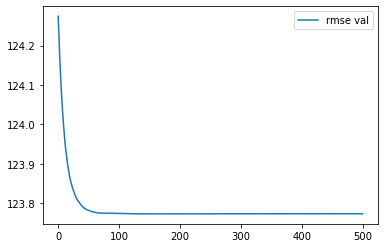

In [48]:

xg_model = XGBRegressor(verbosity=1, n_estimators=500, learning_rate=0.05, max_depth=20)
xg_model.fit(X_train, y_train,
             eval_set=[(X_train, y_train), (X_val, y_val)], verbose=True)
max_estimators = len(xg_model.evals_result()['validation_1']['rmse'])
print(max_estimators)
pd.DataFrame(xg_model.evals_result()['validation_1']['rmse'], columns=['rmse val']).plot()


### Apparently, the model wasn't able to extract a lot of information usefull for decreasing the loss, for both train and validation set. This indicates that the attributes we might not be adequate for predicting the purchase count. 

<AxesSubplot:>

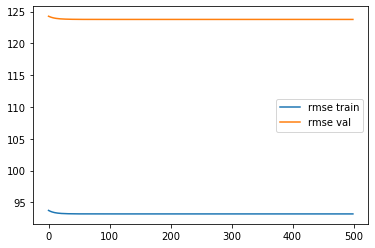

In [49]:
pd.DataFrame(np.transpose([xg_model.evals_result()['validation_0']['rmse'], xg_model.evals_result()['validation_1']['rmse']]), columns=['rmse train', 'rmse val']).plot()

### Here we print the mean absolute error for the train, val and test sets. Surprisingly, the mean absolute error of approx 9 doesn't look so bad, since, as we can see by the density plot further bellow, most of the train targets values are inside the interval from 0 to 100 product purchase counts. 

In [50]:
predictions = xg_model.predict(X_train)
print("Train Mean Absolute Error : {}".format(mean_absolute_error(y_train, predictions)))
print("Train Targets std: {}".format(np.sqrt(y_train.var().item())))
print("Train Targets mean: {}".format(np.sqrt(y_train.mean().item())))


Train Mean Absolute Error : 9.149329608047232
Train Targets std: 93.58857560854715
Train Targets mean: 2.6190002909238737


In [51]:
predictions = xg_model.predict(X_val)
print("Validation Mean Absolute Error : {}".format(mean_absolute_error(predictions, y_val)))
print("Validation Targets std: {}".format(np.sqrt(y_val.var().item())))
print("Train Targets mean: {}".format(np.sqrt(y_val.mean().item())))

Validation Mean Absolute Error : 9.555786987380355
Validation Targets std: 124.14448597429352
Train Targets mean: 2.675133826553521


In [52]:
predictions = xg_model.predict(X_test)
print("Test Mean Absolute Error : {}".format(mean_absolute_error(predictions, y_test)))
print("Test Targets std: {}".format(np.sqrt(y_test.var().item())))
print("Train Targets mean: {}".format(np.sqrt(y_test.mean().item())))

Test Mean Absolute Error : 9.087768804899351
Test Targets std: 64.7312051602059
Train Targets mean: 2.5912503528607975


<AxesSubplot:ylabel='Density'>

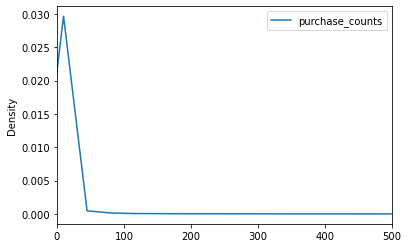

In [53]:
y_train.plot(kind='density', xlim=(-0.1, 500))

### Now we plot the feature importance graphs. The 'weight' graph shows the same dominance of the affiliate_commission_percentual that was present in the feature importance for the experiments in 2) and 3). But now something different happened with the 'cover' and 'gain' graphs. A single variable called "purchase_origin_Origin 18eb", that wasn't present in any feature importance graph in the previous experiments, dominated the feature importance. Other new attributes "product_niche_Youtube_video_creation' and 'product_niche_immigration' also weren't present in previous feature importance maps, and are shown to be of great importance for the prediction of this experiment.

<AxesSubplot:title={'center':'Feature importance: gain'}, xlabel='F score', ylabel='Features'>

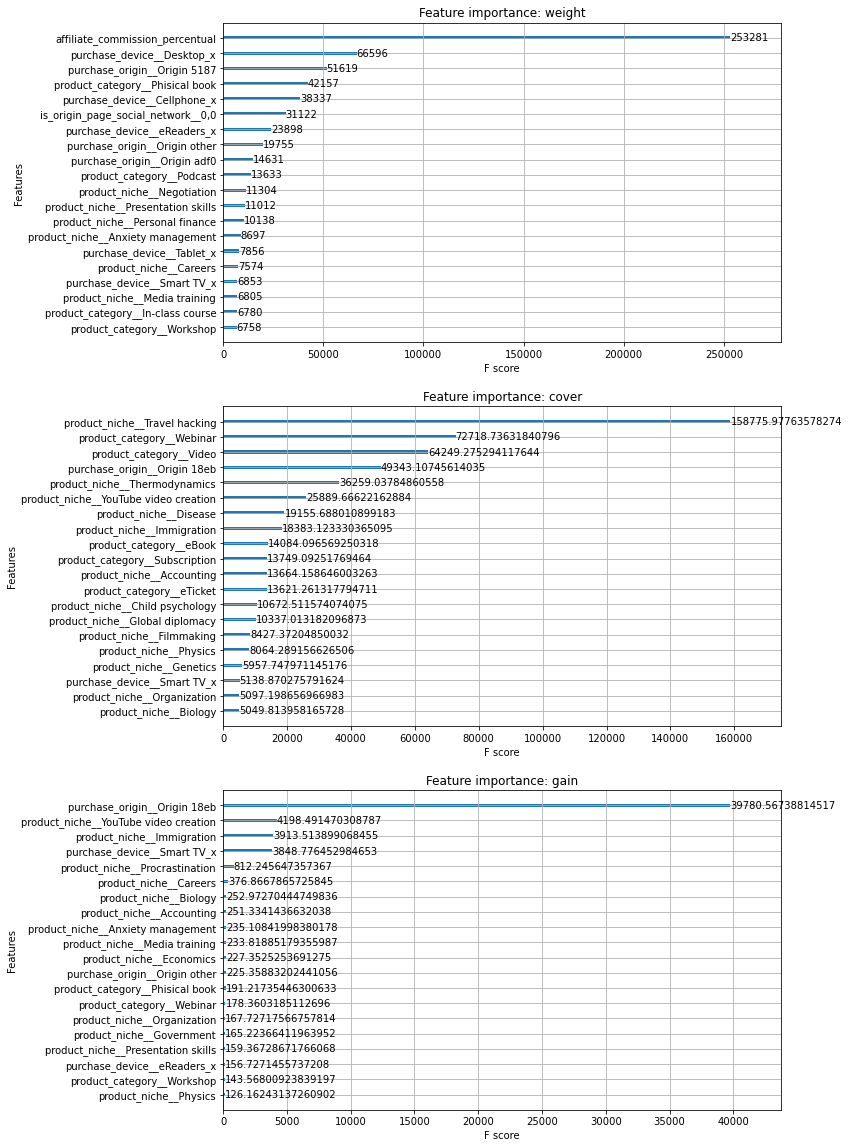

In [54]:

fig, ax = plt.subplots(figsize=(10,20), nrows=3)
xgb.plot_importance(xg_model, max_num_features=20,importance_type='weight', ax=ax[0], title='Feature importance: weight')
xgb.plot_importance(xg_model, max_num_features=20,importance_type='cover', ax=ax[1], title='Feature importance: cover')
xgb.plot_importance(xg_model, max_num_features=20,importance_type='gain', ax=ax[2], title='Feature importance: gain')